In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [13]:
#import datsets from tensorflow-mnist
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

In [14]:
#load data
data_dir = 'temp'
mnist = read_data_sets(data_dir)

#convert data into 28*28
train_xdata = np.array([np.reshape(x,(28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])

#convert lables one-hot-encoder
train_lables = mnist.train.labels
test_lables = mnist.test.labels


Extracting temp\train-images-idx3-ubyte.gz
Extracting temp\train-labels-idx1-ubyte.gz
Extracting temp\t10k-images-idx3-ubyte.gz
Extracting temp\t10k-labels-idx1-ubyte.gz


In [15]:
#create a graph
sess = tf.Session()

#set model parameters
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = 28
image_height = 28
target_size = max(train_lables)+1 #10
num_channels = 1
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool1 = 2
max_pool2 = 2
fully_connected_size1 = 100

#model placehoders
x_input_shape = (batch_size, image_width,image_height,num_channels)
x_input = tf.placeholder(dtype=tf.float32, shape=x_input_shape)
y_target = tf.placeholder(dtype=tf.int32, shape=(batch_size))

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(dtype=tf.float32, shape=(eval_input_shape))
eval_target = tf.placeholder(dtype=tf.int32, shape=(evaluation_size))


#model parameters

conv1_weights = tf.Variable(tf.truncated_normal([4,4,num_channels,conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
                         
conv2_weights = tf.Variable(tf.truncated_normal([4,4,conv1_features,conv2_features], stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features],dtype=tf.float32))

#fully_conected variables
resulting_width = image_width // (max_pool1 * max_pool2)
resulting_height = image_height // (max_pool1 * max_pool2)
full1_input_shape = resulting_height * resulting_width * conv2_features

full1_weights = tf.Variable(tf.truncated_normal([full1_input_shape, fully_connected_size1], stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))

full2_weights = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))                       

In [16]:
#initialize model operation
def my_conv_net(input_data):
    #1st conv-relu-maxpool layer 
    conv1 = tf.nn.conv2d(input_data,conv1_weights, strides=[1,1,1,1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool_layer1 = tf.nn.max_pool(relu1, ksize=[1, max_pool1,max_pool1,1], strides=[1,max_pool1, max_pool1,1], padding='SAME')
    
    #2nd layer
    conv2 = tf.nn.conv2d(max_pool_layer1, conv2_weights, strides=[1,1,1,1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2,conv2_bias))
    max_pool_layer2 = tf.nn.max_pool(relu2, ksize=[1, max_pool2,max_pool2,1], strides=[1,max_pool2, max_pool2,1], padding='SAME')
    
    #transfer o/p into 1*N
    final_conv_shape = max_pool_layer2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool_layer2, [final_conv_shape[0], final_shape])
    
    #fully-connected layer 
    fully_conneceted1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weights), full1_bias))
    final_model_output = tf.nn.relu(tf.add(tf.matmul(fully_conneceted1, full2_weights), full2_bias))
    
    return(final_model_output)

model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)
    

In [17]:
#loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

#create an optimizer
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)

#create pred func
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

# Create accuracy function
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return(100. * num_correct/batch_predictions.shape[0])

In [18]:
#initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [21]:
# Start training loop
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_lables[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if (i+1) % eval_every == 0:
        eval_index = np.random.choice(len(test_xdata), size=evaluation_size)
        eval_x = test_xdata[eval_index]
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_lables[eval_index]
        test_dict = {eval_input: eval_x, eval_target: eval_y}
        test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(test_preds, eval_y)
        
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    

Generation # 5. Train Loss: 2.26. Train Acc (Test Acc): 20.00 (21.20)
Generation # 10. Train Loss: 2.20. Train Acc (Test Acc): 24.00 (31.40)
Generation # 15. Train Loss: 2.07. Train Acc (Test Acc): 34.00 (33.00)
Generation # 20. Train Loss: 2.14. Train Acc (Test Acc): 26.00 (28.40)
Generation # 25. Train Loss: 1.89. Train Acc (Test Acc): 41.00 (34.80)
Generation # 30. Train Loss: 1.80. Train Acc (Test Acc): 44.00 (39.60)
Generation # 35. Train Loss: 1.83. Train Acc (Test Acc): 36.00 (42.60)
Generation # 40. Train Loss: 1.63. Train Acc (Test Acc): 50.00 (44.40)
Generation # 45. Train Loss: 1.82. Train Acc (Test Acc): 37.00 (48.00)
Generation # 50. Train Loss: 1.56. Train Acc (Test Acc): 51.00 (57.00)
Generation # 55. Train Loss: 1.29. Train Acc (Test Acc): 64.00 (57.80)
Generation # 60. Train Loss: 1.20. Train Acc (Test Acc): 63.00 (57.80)
Generation # 65. Train Loss: 0.93. Train Acc (Test Acc): 75.00 (61.80)
Generation # 70. Train Loss: 0.93. Train Acc (Test Acc): 74.00 (69.80)
Generat

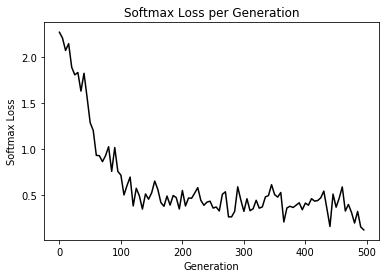

In [23]:
#Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

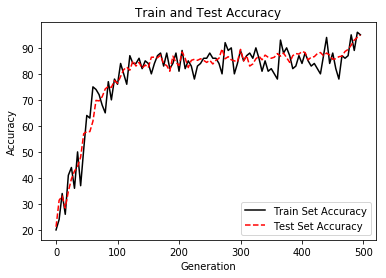

In [24]:
# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()